In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/learn-ai-bbc/BBC News Train.csv
/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv
/kaggle/input/learn-ai-bbc/BBC News Test.csv


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, accuracy_score
plt.style.use('ggplot')
from sklearn.metrics import rand_score,mutual_info_score,jaccard_score,fowlkes_mallows_score

#nlp related
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
import re
import string
from sklearn import feature_extraction, linear_model, model_selection, preprocessing


from collections import  Counter
from collections import defaultdict

np.random.seed(42)


In [3]:
#Load the data using pandas : Create a DataFrame named df, that contains the training data 
df = pd.read_csv('../input/learn-ai-bbc/BBC News Train.csv')
df_submit = pd.read_csv('../input/learn-ai-bbc/BBC News Test.csv')
print('train set shape: ', df.shape)
print('test set shape:', df_submit.shape)
df.head()

train set shape:  (1490, 3)
test set shape: (735, 2)


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


### Step 1 
Extracting word features and show Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [4]:
#df['target'] = df['Category'].astype('category').cat.codes
id_category_mapping = {
  "business" : 0,
  "entertainment" : 1,
  "politics" : 2,
  "sport" : 3,
  "tech" : 4
}
df["target"] = df["Category"].map(id_category_mapping)
df

,ArticleId,Text,Category,target
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,4
4,917,enron bosses in $168m payout eighteen former e...,business,0
...,...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment,1
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment,1
1487,1590,weak dollar hits reuters revenues at media gro...,business,0
1488,1587,apple ipod family expands market apple has exp...,tech,4


sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64


Text(0.5, 0, 'Class type')

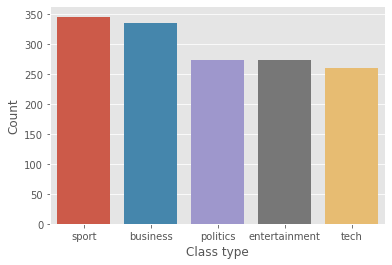

In [5]:
count = df.Category.value_counts()
sns.barplot(x=count.index, y=count) #, color='#CFB87C'
print(count)
plt.ylabel("Count")
plt.xlabel("Class type")

### Text cleaning common practice
1. Removing/Retaining Stopwords
2. Lemmatizing/Stemming
3. Spell correction
4. Removing special symbols like urls, emoji, 

In [6]:
def clean_text(text):
    # punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$£￥=><|{}^' + "'`"
    for p in punctuations:
        text = text.replace(p, f' {p} ')
    
    #
    table = str.maketrans('','',string.punctuation)
    text = text.translate(table)
        
        
    return text

df['Text'] = df['Text'].apply(lambda s : clean_text(s))
df_submit['Text'] = df_submit['Text'].apply(lambda s : clean_text(s))

df

,ArticleId,Text,Category,target
0,1833,worldcom ex boss launches defence lawyers def...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,4
4,917,enron bosses in 168m payout eighteen former ...,business,0
...,...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment,1
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment,1
1487,1590,weak dollar hits reuters revenues at media gro...,business,0
1488,1587,apple ipod family expands market apple has exp...,tech,4


Creat corpus, a list contain all words in datasets. Then count and plot most common stop words.

In [7]:
def create_corpus(category, df):
    corpus=[]
    
    if category is None:
        for x in df['Text'].str.split():
            for i in x:
                corpus.append(i)
        
    else:
        for x in df[df['Category']==category]['Text'].str.split():
            for i in x:
                corpus.append(i)
            
    return corpus


all_corpus = create_corpus(None, df)
cor_bu = create_corpus('business', df)
cor_tech = create_corpus('tech', df)
cor_pol = create_corpus('politics', df)
cor_sport = create_corpus('sport', df)
cor_ent = create_corpus('entertainment', df)

In [8]:
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))

counter = Counter(all_corpus)
most = counter.most_common()
x_0, y_0 = [], []
for word,count in most[:80]:
    if (word not in stop):
        x_0.append(word)
        y_0.append(count)

counter = Counter(cor_bu)
most = counter.most_common()
x_1, y_1 = [], []
for word,count in most[:60]:
    if (word not in stop) :
        x_1.append(word)
        y_1.append(count)

counter = Counter(cor_tech)
most = counter.most_common()
x_tech, y_tech = [], []
for word,count in most[:60]:
    if (word not in stop) :
        x_tech.append(word)
        y_tech.append(count)

        
counter = Counter(cor_pol)
most = counter.most_common()
x_pol, y_pol = [], []
for word,count in most[:60]:
    if (word not in stop) :
        x_pol.append(word)
        y_pol.append(count)
        
counter = Counter(cor_sport)
most = counter.most_common()
x_4, y_4 = [], []
for word,count in most[:60]:
    if (word not in stop) :
        x_4.append(word)
        y_4.append(count)
        
counter = Counter(cor_ent)
most = counter.most_common()
x_5, y_5 = [], []
for word,count in most[:60]:
    if (word not in stop) :
        x_5.append(word)
        y_5.append(count)

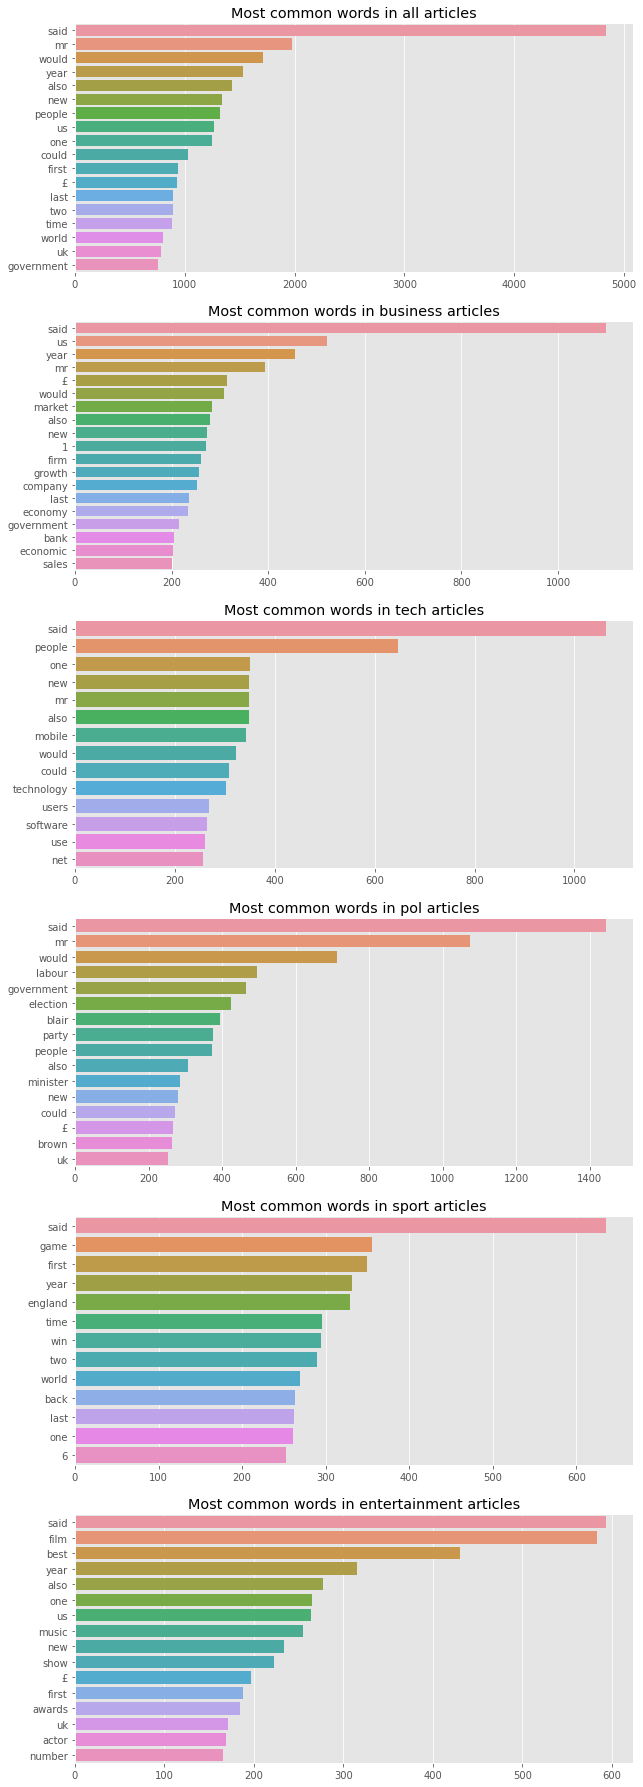

In [9]:

f, axes = plt.subplots(6, 1, figsize=(10,32))
sns.barplot(ax=axes[0], x=y_0,y=x_0)
axes[0].set_title('Most common words in all articles')

sns.barplot(ax=axes[1], x=y_1,y=x_1)
axes[1].set_title('Most common words in business articles')

sns.barplot(ax=axes[2], x=y_tech,y=x_tech)
axes[2].set_title("Most common words in tech articles")

sns.barplot(ax=axes[3], x=y_pol,y=x_pol)
axes[3].set_title("Most common words in pol articles")

sns.barplot(ax=axes[4], x=y_4,y=x_4)
axes[4].set_title("Most common words in sport articles")

sns.barplot(ax=axes[5], x=y_5,y=x_5)
axes[5].set_title("Most common words in entertainment articles")
plt.show()

----

#### Build word vectors
1. Count vectorizer and TF-IDF were used.
2. count vector: matrix columns are words appear in all text, and each row indicate article id i contain certain words, if contain the word the row is 1, otherwise 0.

2. TF-IDF: This method give vectors importance of related words in document/sentence, unlike bag of words. e.g If a word appear in sentence a lot, TF-IDF will treat it as a common word(a,like, said etc.) and reduce its importance. Here are the formula.

TF=term frequency= number of word appear in sentence / number of word in sentence

IDF = inverse document frequence = log ( number of sentences in doc / number of sentences contain the word)

3. For the result: TF_IDF is slightly better than count vector, in terms of rand score.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#count vector
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', 
                            lowercase=True)
count_vec = vectorizer.fit_transform(df.Text)
print(count_vec.shape)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', 
                        ngram_range=(1,2),stop_words='english')  #unigrams and bigrams

#tfidf = TfidfVectorizer(stop_words='english')
tfidf_vector = tfidf.fit_transform(df.Text)
tfidf_vector_sub = tfidf.fit_transform(df_submit.Text).toarray()

#tfidf_vectorizer = TfidfVectorizer()
#X_train_tf = tfidf_vectorizer.fit_transform(X_train.values)
#X_test_tf = tfidf_vectorizer.fit_transform(X_test)
#submit_tf = tfidf_vectorizer.fit_transform(df_submit['Text'])

print(tfidf_vector.shape)
print(tfidf_vector_sub.shape)

(1490, 7115)
(1490, 9927)
(735, 5306)


In [11]:
#vectorizer text 

# X_train, X_test, y_train, y_test = train_test_split(
#     count_vec, df['target'].values, test_size=0.2, random_state=42)


X_train, X_test, y_train, y_test = train_test_split(
    tfidf_vector, df['target'].values, test_size=0.2, random_state=42)



print(X_train.shape)
print(X_test.shape)
print(y_test.shape)

(1192, 9927)
(298, 9927)
(298,)


In [12]:
from sklearn.manifold import TSNE
np.random.seed(10)

SAMPLE_SIZE = int(tfidf_vector.shape[0] * 0.9)
indices = np.random.choice(range(tfidf_vector.shape[0]), size=SAMPLE_SIZE, replace=False)         
projected_features = TSNE(n_components=2, random_state=0).fit_transform(tfidf_vector[indices]) 
projected_features.shape

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(1341, 2)

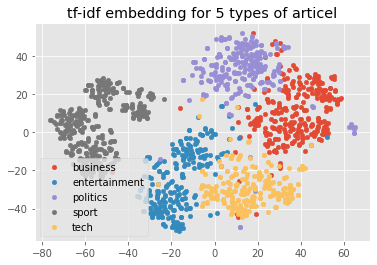

In [13]:
for category, category_id in sorted(id_category_mapping.items()):
    points = projected_features[(df.target[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=20, label=category)

plt.title("tf-idf embedding for 5 types of articel")
plt.legend()
plt.show()

----

### Step 2

Building and training models

**Some thoughts:**
1. Since matrix factorization is consider as unsupersived method, durning training we donnot need to worry about model getting the testset label info, in theory, either  include text or not as input matrix is fine for this problem. And I have tried both, the result is without test matrix the rand score is slightly higher(98.1% vs 97.3%).
2. Building model using NMF, set n_components=5, and tf-idf matrix is more efficient with KL loss. 
3. For measuring performances I use 3 metrics, accuarccy, rand score and fowlkes_mallows_score, the later 2 are better for clusting problem, cause we assume doing unsupervise learning, it's without labels.
4. Display score as result.
5. Improving by fine tunning the model, changing train/test size.


##### Non-Negative Matrix Factorization

In [14]:
%%time 
from sklearn.decomposition import NMF

nmf = NMF(n_components=5, max_iter=500,solver='mu',
          beta_loss='kullback-leibler',random_state=10) 

#nmf.fit(tfidf_vector)
nmf.fit(X_train)
#H = nmf.components_

# print('H',H.shape)
# print('W', W.shape)

/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


CPU times: user 2.13 s, sys: 1.11 s, total: 3.24 s
Wall time: 1.58 s


NMF(beta_loss='kullback-leibler', max_iter=500, n_components=5, random_state=10,
    solver='mu')

In [15]:
#transform test data

pred_prob = nmf.transform(X_test)
#print(pred_prob.shape)

pred_labels = np.argmax(pred_prob, axis=1)


print('acc:', accuracy_score(y_test, pred_labels))
print('rand score', rand_score(y_test, pred_labels))
print('fm score', fowlkes_mallows_score(y_test, pred_labels))

acc: 0.18456375838926176
rand score 0.9810634307278603
fm score 0.9531897364676524


##### Latent Dirichlet Allocation

In [16]:
%%time
# Latent Dirichlet Allocation Model

from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=5, random_state=10)
lda.fit(X_train)


CPU times: user 4.36 s, sys: 1.96 ms, total: 4.37 s
Wall time: 4.37 s


LatentDirichletAllocation(n_components=5, random_state=10)

In [17]:
pred_prob = lda.transform(X_test)


pred_labels = np.argmax(pred_prob, axis=1)
#print(pred_prob)
#print(pred_labels)

print('acc:', accuracy_score(y_test, pred_labels))
print('rand score', rand_score(y_test, pred_labels))
print('fm score', fowlkes_mallows_score(y_test, pred_labels))

acc: 0.18791946308724833
rand score 0.7112060199308522
fm score 0.5811397573216798


In [18]:
%%time
from sklearn.decomposition import FactorAnalysis

transformer = FactorAnalysis(n_components=5, random_state=0)
transformer.fit(X_train.toarray()) 
#X_transformed.shape

pred_prob = transformer.transform(X_test.toarray())

pred_labels = np.argmax(pred_prob, axis=1)
#print(pred_prob)
pred_labels

print('acc:', accuracy_score(y_test, pred_labels))
print('rand score', rand_score(y_test, pred_labels))
print('fm score', fowlkes_mallows_score(y_test, pred_labels))

acc: 0.14429530201342283
rand score 0.7842406164553816
fm score 0.5421081133140944
CPU times: user 19.7 s, sys: 13 s, total: 32.7 s
Wall time: 8.46 s


#### K mean clustering

In [19]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(X_test)
pred_labels = kmeans.labels_
print(pred_labels.shape)

print('acc:', accuracy_score(y_test, pred_labels))
print('rand score', rand_score(y_test, pred_labels))
print('fm score', fowlkes_mallows_score(y_test, pred_labels))

(298,)
acc: 0.02348993288590604
rand score 0.8912390120443812
fm score 0.7395847783156247


rand score: 0.8912390120443812


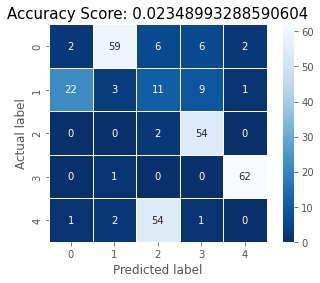

In [20]:
from sklearn.metrics import confusion_matrix,accuracy_score, rand_score


cfm = confusion_matrix(y_test, pred_labels)
acc = accuracy_score(y_test, pred_labels)
sns.heatmap(cfm, annot=True, linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc)
plt.title(all_sample_title, size = 15);

print('rand score:',rand_score(y_test,  pred_labels))

___

### Step 3

Compare with supervised learning

1. 
    * logistic regression: train acc: 0.9966, test acc: 0.983  training time 1.75s
    * suport vector machine, train acc: 1.0  ,test acc: 0.983 time: 6.1s
    * random forest: train 0.985, test:0.96, time 4.5s
    * Naive Bayes classifier for multinomial train 0.992, test 0.983, time 15ms

2. 
    * Fix model to svc and try different data size.
    * 10% test : train 1.0, test 1.0 acc
    * 20% test size: train 1.0, test 0.98
    * 50% test size: train 1.0 ,  test  0.98
    * multinomial naive bayes is the most data efficeint, has lowest runtime and almost hightest score, and if set random forest max_depth and n_estimators to large will overfit.
    

In [21]:
%%time
#logistic on TFIDF
from sklearn.svm import NuSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(
    tfidf_vector, df['target'].values, test_size=0.5, random_state=42)

#clf = linear_model.LogisticRegression()
clf = SVC(kernel='rbf',gamma='scale', C=6)
#clf = RandomForestClassifier(max_depth=10, n_estimators=1000,random_state=0)
#clf = MultinomialNB()


#scores = model_selection.cross_val_score(clf, X_train_tf, y_train, cv=3, scoring="accuracy")
#scores
clf.fit(X_train, y_train)
print(clf.score(X_train,y_train))
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

1.0
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       171
           1       0.98      1.00      0.99       130
           2       0.99      0.95      0.97       142
           3       0.99      1.00      0.99       164
           4       0.96      0.96      0.96       138

    accuracy                           0.98       745
   macro avg       0.98      0.98      0.98       745
weighted avg       0.98      0.98      0.98       745

CPU times: user 3.09 s, sys: 7.11 ms, total: 3.1 s
Wall time: 3.15 s


rand score: 0.9820632171465685


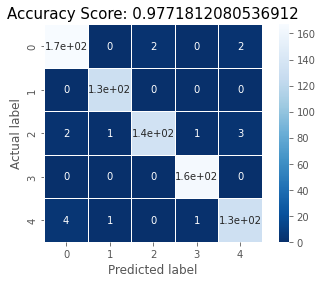

In [22]:
from sklearn.metrics import confusion_matrix,accuracy_score, rand_score


cfm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
sns.heatmap(cfm, annot=True, linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc)
plt.title(all_sample_title, size = 15);

print('rand score:',rand_score(y_test, y_pred))

-------

### Step 4

Submission and Organized Jupyter Notebook Report

Github link for the nodebook: https://github.com/carsonxie/Machine-Learning-Projects/tree/main/NLP_News%20Classification%20Project

Reference: 

https://towardsdatascience.com/nmf-a-visual-explainer-and-python-implementation-7ecdd73491f8

https://www.kaggle.com/code/thebrownviking20/topic-modelling-with-spacy-and-scikit-learn

https://www.kaggle.com/code/aryankaul31/aryan-bbc-news-classification